In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from helpers import *
from torch.autograd import Variable

%matplotlib inline

In [2]:
N = 100      # size of toy data

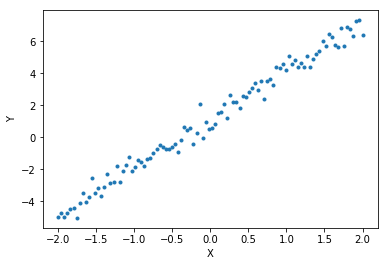

In [3]:
def build_linear_dataset(N, noise_std=0.5):
    X = np.linspace(-2, 2, num=N)
    Y = 3 * X + 1 + np.random.normal(0, noise_std, size=N)
    X, Y = X.reshape((N, 1)), Y.reshape((N, 1))
    return X, Y

X, Y = build_linear_dataset(N)

X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

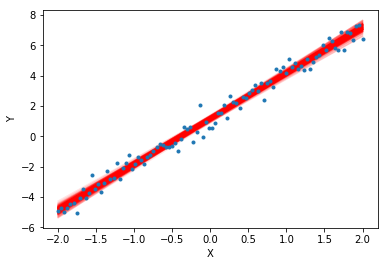

In [4]:
# posterior with bayesian linear regression

alpha = 0.01  # precision of isotropic Gaussian prior on weight
betam = 1.    # precision of model noise

m0 = 0.
S0 = 1/alpha*np.eye(2)
Phi = np.array([X.squeeze(), 
                np.ones((len(X)))]).T

SN = np.linalg.inv(alpha+betam*np.dot(Phi.T, Phi))
mN = betam*np.dot(SN, np.dot(Phi.T, Y))

for r in range(250):
    sampam = np.random.multivariate_normal(mN.squeeze(), SN, 1)
    plt.plot(X, np.dot(sampam.squeeze(), np.array([X, 1])), '-r', alpha=0.1)
plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

In [5]:
model = MDN(svi=True, n_samples=1000)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

def train(X, Y, n_epochs=500, n_minibatch=10):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_alpha, out_sigma, out_mu) = model(x_var)
            
            if model.svi:
                y_var = y_var[None, :, :].expand(model.n_samples, x_var.size()[0], 1).contiguous().view(-1, 1)
            loss = -torch.mean(mdn_logloss(out_alpha, out_sigma, out_mu, y_var))
            loss += 1/N*mdn_kl(model.mu, model.logsigma, 0.01)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
        
train(X, Y)

[epoch 0050] loss: 1.6373
[epoch 0100] loss: 1.4977
[epoch 0150] loss: 1.4030
[epoch 0200] loss: 1.3564
[epoch 0250] loss: 1.2732
[epoch 0300] loss: 1.2853
[epoch 0350] loss: 1.2147
[epoch 0400] loss: 1.2332
[epoch 0450] loss: 1.3213
[epoch 0500] loss: 1.3128


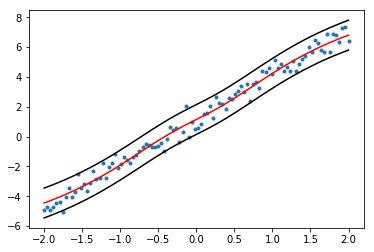

In [6]:
X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var, sample=False)

plt.plot(X, Y, '.')
plt.plot(X, out_mu.data.numpy(), '-r');
plt.plot(X, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');

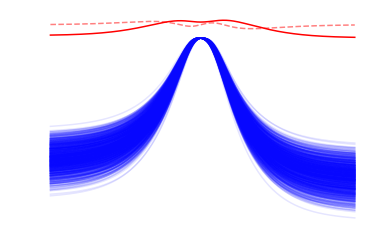

argmax C(θ)=1.406 with β=0.8


In [8]:
thetas = np.linspace(-10, 10, 250)

Cs = []
C_grads = []
Lps = []

beta = 0.8  # beta in [0,1]. 1=mean, 0=var

for theta in thetas:
    C, C_grad, Lp = al_loss(model, 
                            prior_mean=0., 
                            prior_var=1/alpha, 
                            theta=np.array([theta]), 
                            obs=np.array([0.8]),
                            beta=beta, frozen=True)  
    Cs.append(C)
    C_grads.append(C_grad)
    Lps.append(Lp)

plt.plot(thetas, Lps, '-b', alpha=0.1);
plt.plot(thetas, Cs, '-r');
plt.plot(thetas, C_grads, '--r', alpha=0.5);
plt.axis('off');
plt.show();

print('argmax C(θ)={:.3f} with β={}'.format(thetas[np.nanargmax(Cs)], beta))
if np.any(np.isnan(Cs)) or np.any(np.isnan(C_grad)):
    print('Warning: Cs/Cs_grad contain NaNs')

In [9]:
def optimize(loss_fun, theta_init, maxiter=100, verbose=False):
    """
    loss_fun : function
        Takes a single arg for evaluation. Returns value and grad as first and second output
    """
    alpha = 0.1
    done = False
    ti = theta_init
    Lo = np.inf
    i = 0
    
    if verbose:
        pbar = tqdm()
    
    while not done and i < maxiter:
        out = loss_fun(ti)
        L = -out[0].squeeze()
        g = -out[1].squeeze()
        assert not np.isinf(g)
        assert not np.isnan(g)
        
        ti -= alpha * g
        if np.abs(Lo - L) < 1e-6 * Lo + 1e-6:
            done = True
        Lo = L
        i += 1
        
        if verbose:
            pbar.update()
    return ti

loss_fun = lambda theta: al_loss(model, prior_mean=0., prior_var=1/alpha, \
                                 theta=np.array([theta]), obs=np.array([0.8]), \
                                 beta=beta)

In [10]:
tic = time.time()
t_star = optimize(loss_fun, theta_init=0.1)

print('time elapsed : {:.2f}s'.format(time.time()-tic))
print('theta* = {:.2f}'.format(t_star))

time elapsed : 1.10s
theta* = 1.39
